# Creación y Activación del entorno virtual

Se trabajará con WSL para poder generar el entorno virtual, es importante abrir Visual Studio desde WSL con el comando "code ." estando adentro del directorio del proyecto. Se utiliza requirements.txt para poder descargar las libreríás asociadas al entrenamiento del modelo que utilizaremos

In [1]:
%%bash
set -e

# === Configuración ===
REQ="requirements_train.txt"   # cambia a "requirements.txt" si lo prefieres
PYTHON_BIN="python3.12"        # versión forzada
VENV_DIR=".venv_rps"           # nombre personalizado del entorno

echo "==> Detectando distribución..."
DISTRO=$(grep '^ID=' /etc/os-release | cut -d'=' -f2 | tr -d '"')
echo "Sistema detectado: $DISTRO"

# === Instalar Python 3.12 si falta ===
if ! command -v $PYTHON_BIN &>/dev/null; then
  echo "⚠️  Python 3.12 no encontrado, instalando..."

  case "$DISTRO" in
    ubuntu|debian|wsl)
      echo "==> Usando APT (Ubuntu/Debian/WSL)"
      sudo apt update -y
      sudo apt install -y software-properties-common
      sudo add-apt-repository ppa:deadsnakes/ppa -y
      sudo apt install -y python3.12 python3.12-venv python3.12-dev
      ;;
    fedora)
      echo "==> Usando DNF (Fedora)"
      sudo dnf install -y python3.12 python3.12-devel
      ;;
    *)
      echo "⚠️  Distro no reconocida: $DISTRO"
      echo "➡️  Instala Python 3.12 manualmente antes de continuar."
      exit 1
      ;;
  esac
else
  echo "✅ Python 3.12 detectado correctamente."
fi

# === Crear entorno virtual ===
echo "==> Activando/creando entorno en $VENV_DIR"
if [ ! -d "$VENV_DIR" ]; then
  $PYTHON_BIN -m venv "$VENV_DIR"
fi
source "$VENV_DIR/bin/activate"

# === Ajustes de rendimiento ===
echo "==> Limitando hilos BLAS"
export OMP_NUM_THREADS=1
export MKL_NUM_THREADS=1

# === Actualizar pip ===
echo "==> Actualizando pip"
python -m pip install -U pip --quiet

# === Instalar dependencias ===
echo "==> Instalando dependencias necesarias"
if [ -f "$REQ" ]; then
  python -m pip install -r "$REQ" --prefer-binary --exists-action=i --no-warn-script-location
else
  echo "⚠️  No se encontró $REQ; instalando paquetes básicos..."
  python -m pip install matplotlib numpy pillow tensorflow kagglehub ipykernel --quiet
fi

# === Registrar kernel de Jupyter ===
echo "==> Registrando kernel en Jupyter..."
python -m ipykernel install --user --name="$VENV_DIR" --display-name "Python ($VENV_DIR)"

# === Resumen ===
echo "✅ Entorno virtual creado correctamente:"
echo "   🐍 Python: $(python --version)"
echo "   📦 Ubicación: $(python -c 'import sys; print(sys.executable)')"
echo "   📘 Kernel: Python ($VENV_DIR)"
echo "➡️  Selecciónalo en Jupyter: Kernel > Change Kernel > Python ($VENV_DIR)"


==> Detectando distribución...
Sistema detectado: fedora
✅ Python 3.12 detectado correctamente.
==> Activando/creando entorno en .venv_rps
==> Limitando hilos BLAS
==> Actualizando pip
==> Instalando dependencias necesarias
==> Registrando kernel en Jupyter...
Installed kernelspec .venv_rps in /home/germanfernandez/.local/share/jupyter/kernels/.venv_rps
✅ Entorno virtual creado correctamente:
   🐍 Python: Python 3.12.12
   📦 Ubicación: /home/germanfernandez/Documentos/RockPaperScissor-NN-DL-main/.venv_rps/bin/python
   📘 Kernel: Python (.venv_rps)
➡️  Selecciónalo en Jupyter: Kernel > Change Kernel > Python (.venv_rps)


In [2]:
%%bash
python3 --version

Python 3.13.9


# Importar Dataset

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

Path to dataset files: /home/germanfernandez/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


In [10]:
print(path)

/home/germanfernandez/.cache/kagglehub/datasets/drgfreeman/rockpaperscissors/versions/2


Clases disponibles: ['paper', 'rock', 'rps-cv-images', 'scissors']


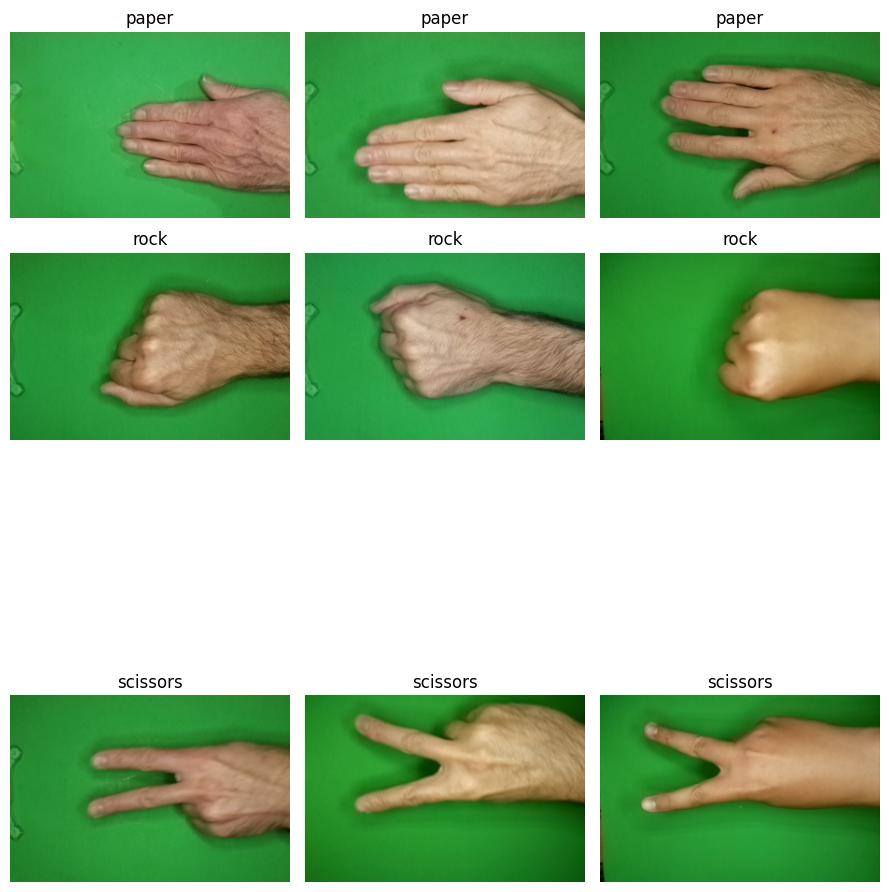

In [11]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Tu path ya apunta a la raíz correcta
data_dir = path

# Filtramos solo las carpetas válidas (sin archivos README u otras)
classes = [d for d in os.listdir(data_dir)
           if os.path.isdir(os.path.join(data_dir, d))]
print("Clases disponibles:", classes)

# Mostrar 3 imágenes aleatorias por clase
plt.figure(figsize=(9, 9))

for i, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_dir)
              if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Tomamos hasta 3 imágenes aleatorias
    n = min(3, len(images))
    for j, img_name in enumerate(random.sample(images, n)):
        img_path = os.path.join(class_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(len(classes), 3, i * 3 + j + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()


# Mediapipe

In [12]:
import mediapipe as mp

mp_hands = mp.solutions.hands
print("✅ MediaPipe cargado correctamente:", mp_hands)


✅ MediaPipe cargado correctamente: <module 'mediapipe.python.solutions.hands' from '/home/germanfernandez/Documentos/RockPaperScissor-NN-DL-main/.venv_rps/lib64/python3.12/site-packages/mediapipe/python/solutions/hands.py'>


I0000 00:00:1761329764.636055    4455 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1761329764.639833    4966 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.1.9), renderer: AMD Radeon Vega 10 Graphics (radeonsi, raven, ACO, DRM 3.64, 6.17.4-200.fc42.x86_64)
W0000 00:00:1761329764.700961    4957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761329764.723663    4955 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


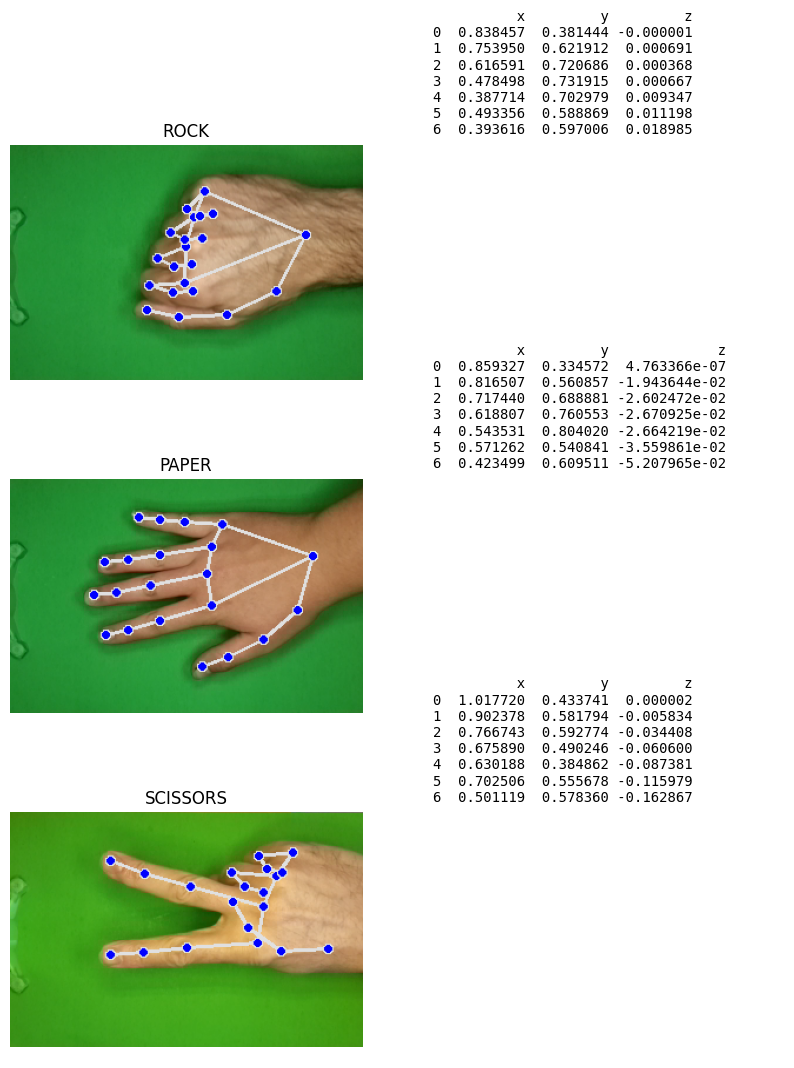

In [14]:
from PIL import Image
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd

# Inicializar MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Clases principales
classes = ["rock", "paper", "scissors"]

# Crear figure
fig, axs = plt.subplots(3, 2, figsize=(10, 12))
plt.subplots_adjust(hspace=0.3)

for i, label in enumerate(classes):
    folder = os.path.join(path, label)
    img_name = random.choice([
        f for f in os.listdir(folder)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])
    img_path = os.path.join(folder, img_name)

    # Cargar imagen con Pillow
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)

    # Procesar con MediaPipe
    result = hands.process(img_array)

    if result.multi_hand_landmarks:
        hand_landmarks = result.multi_hand_landmarks[0]
        # Dibujar landmarks sobre la imagen
        annotated_img = img_array.copy()
        mp_drawing.draw_landmarks(
            annotated_img,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS
        )

        # Extraer (x, y, z)
        landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()

        # Mostrar imagen con landmarks
        axs[i, 0].imshow(annotated_img)
        axs[i, 0].set_title(f"{label.upper()}")
        axs[i, 0].axis("off")

        # Mostrar resumen del vector (primeros 7 puntos)
        vector_df = pd.DataFrame(landmarks.reshape(-1, 3), columns=["x", "y", "z"])
        axs[i, 1].axis("off")
        axs[i, 1].text(0, 1, str(vector_df.head(7)), fontsize=10, family="monospace")

hands.close()
plt.show()


MediaPipe es una librería desarrollada por Google, que incluye una CNN (red neuronal convolucional) previamente entrenada para detectar 21 puntos clave (landmarks) de la mano humana en tiempo real. Cada uno de esos puntos representa una articulación o zona relevante de los dedos y la palma, lo que permite obtener una representación precisa de la pose de la mano a partir de una simple imagen o video.

En este proyecto, utilizamos MediaPipe como una herramienta de extracción de características en lugar de entrenar una red desde cero con imágenes crudas, aprovechamos su modelo ya entrenado con millones de manos y fondos distintos para obtener los vectores de coordenadas (x, y, z) de los 21 puntos de la mano. De esta forma, cada imagen del dataset de piedra, papel o tijeras se convierte en un vector numérico de 63 valores, que describe la forma y posición de la mano en el espacio.
Estos vectores son los que luego usaramos como entrada para un clasificador de aprendizaje automático: un SVM y una red neuronal simple, que serán los encargados de determinar si la mano corresponde a piedra, papel o tijeras, comparando el resultado entre ambos modelos, buscando el mejor score posible.

## Paso 1) Vectorizar todas las imagenes mediante Mediapipe y guardarlo en un csv

In [15]:
from PIL import Image
import mediapipe as mp
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# Inicializar MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

# Clases a procesar
classes = ["rock", "paper", "scissors"]

data = []
labels = []

# Recorremos cada clase
for label in classes:
    folder = os.path.join(path, label)
    for file in tqdm(os.listdir(folder), desc=f"Procesando {label}"):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder, file)
            try:
                img = Image.open(img_path).convert("RGB")
                img_array = np.array(img)
                result = hands.process(img_array)
                if result.multi_hand_landmarks:
                    hand_landmarks = result.multi_hand_landmarks[0]
                    # Vector (x, y, z)
                    landmarks = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
                    data.append(landmarks)
                    labels.append(label)
            except Exception as e:
                print(f"⚠️ Error con {file}: {e}")

hands.close()

# Convertir a DataFrame
df = pd.DataFrame(data)
df["label"] = labels

# Guardar en CSV
output_csv = "dataset_landmarks.csv"
df.to_csv(output_csv, index=False)

print(f"✅ Dataset guardado correctamente en: {output_csv}")
print(f"📊 Total de muestras: {len(df)}")
print(f"🧩 Dimensión de cada vector: {df.shape[1]-1} (más la etiqueta)")


I0000 00:00:1761329776.001079    4455 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1761329776.004506    4987 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 25.1.9), renderer: AMD Radeon Vega 10 Graphics (radeonsi, raven, ACO, DRM 3.64, 6.17.4-200.fc42.x86_64)
Procesando rock:   0%|                                                                                                                                                                      | 0/726 [00:00<?, ?it/s]W0000 00:00:1761329776.057884    4976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1761329776.089599    4977 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Procesando scissors: 100%|████████████████████████████████████████████████████████████████████████████████████████████

✅ Dataset guardado correctamente en: dataset_landmarks.csv
📊 Total de muestras: 2049
🧩 Dimensión de cada vector: 63 (más la etiqueta)


In [17]:
import pandas as pd

df = pd.read_csv("dataset_landmarks.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,label
0,0.924075,0.644556,-1.064139e-06,0.791085,0.838683,0.012250,0.642565,0.924844,0.012095,0.493353,...,0.600092,0.408401,0.039117,0.634202,0.440418,0.068997,0.675896,0.445888,0.083232,rock
1,0.732561,0.462394,-1.033660e-06,0.637157,0.671288,0.005682,0.507215,0.782143,0.005757,0.379005,...,0.411540,0.307682,0.027724,0.449253,0.329983,0.050910,0.487481,0.332463,0.064482,rock
2,0.729638,0.438797,-9.052355e-07,0.633915,0.633239,0.009536,0.492795,0.720749,0.006282,0.356383,...,0.371243,0.207696,-0.028462,0.409443,0.221413,-0.002147,0.453790,0.223310,0.017023,rock
3,0.806674,0.379482,-7.228206e-07,0.767215,0.583607,-0.009437,0.670119,0.706103,-0.023996,0.562337,...,0.511751,0.336667,-0.047405,0.543859,0.341134,-0.022568,0.576796,0.325317,-0.006527,rock
4,0.879022,0.584372,-1.013838e-06,0.766052,0.779406,0.005653,0.622841,0.845221,0.003826,0.484276,...,0.583115,0.389951,0.017297,0.618510,0.425059,0.044071,0.656511,0.431070,0.058239,rock


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049 entries, 0 to 2048
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       2049 non-null   float64
 1   1       2049 non-null   float64
 2   2       2049 non-null   float64
 3   3       2049 non-null   float64
 4   4       2049 non-null   float64
 5   5       2049 non-null   float64
 6   6       2049 non-null   float64
 7   7       2049 non-null   float64
 8   8       2049 non-null   float64
 9   9       2049 non-null   float64
 10  10      2049 non-null   float64
 11  11      2049 non-null   float64
 12  12      2049 non-null   float64
 13  13      2049 non-null   float64
 14  14      2049 non-null   float64
 15  15      2049 non-null   float64
 16  16      2049 non-null   float64
 17  17      2049 non-null   float64
 18  18      2049 non-null   float64
 19  19      2049 non-null   float64
 20  20      2049 non-null   float64
 21  21      2049 non-null   float64
 22  

## Crear un train set y test set

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df.drop(columns=["label"]).values
y = df["label"].values

# Codificar etiquetas en números (rock=0, paper=1, scissors=2)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Dividir dataset en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)


Tamaño de X_train: (1639, 63)
Tamaño de X_test: (410, 63)


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Escalar los datos (SVM funciona mejor con datos normalizados)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo SVM
svm_model = SVC(kernel="rbf", C=1.0, gamma="scale")

# Entrenar
svm_model.fit(X_train_scaled, y_train)

# Predecir en test
y_pred = svm_model.predict(X_test_scaled)

# Evaluar resultados
print("\n=== Resultados del modelo SVM ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%\n")
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))



=== Resultados del modelo SVM ===
Accuracy: 100.00%

Matriz de confusión:
[[140   0   0]
 [  0 134   0]
 [  0   0 136]]

Reporte de clasificación:
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       140
        rock       1.00      1.00      1.00       134
    scissors       1.00      1.00      1.00       136

    accuracy                           1.00       410
   macro avg       1.00      1.00      1.00       410
weighted avg       1.00      1.00      1.00       410



In [21]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5)
print("Accuracy promedio en 5-fold CV:", scores.mean())
print("Desviación estándar:", scores.std())


Accuracy promedio en 5-fold CV: 0.998167002312225
Desviación estándar: 0.0024455534975384536


Aunque mediante cross validation y aunque se haya probado el modelo, este tiene un 100% de accuracy, sin embargo, es importante analizar qué haremos en caso de que un oponente elija una opción que no es ni piedra, ni papel, ni tijeras. Por tanto, necesitamos conseguir varias imagenes, que no sean piedra, papel o tijera. También debemos implementar una red neuronal que rivalice la SVM.